In [10]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
import time 
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)


<module 'helper' from '../src\\helper.py'>

In [11]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/07_30_2020_batch_1_6_qTOF_polar_non_polar_peak_areas.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[5:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/07_30_2020_batch_1_6_qTOF_polar_non_polar_experiment_parameters.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

#create sample name, ventilator status linkage
vent_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
        

print(np.sum(list(vent_dict.values()))," vent+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values()))," vent- samples")

#link vent status to sample in peak data
vent_status = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
    else:
        vent_status.append(-1)

print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

#create sample matrix
samp_batch = np.array(batchInfo)[samp][samplesOfInterest]
samp_int = areaData[samp][samplesOfInterest]
samp_vent = np.array(vent_status)[samplesOfInterest]

#create blank matrix
blank_batch = np.array(batchInfo)[blankSamp]
blank_int = areaData[blankSamp]

#create qc matrix
qc_batch = np.array(batchInfo)[qcSamp]
qc_int = areaData[qcSamp]

0  blanks
0  qc samples
442 research samples
168  d0 Covid+ Samples
31  vent+ samples
137  vent- samples
found vent info for 168 covid_ d0 samples


No handles with labels found to put in legend.


Text(0, 0.5, 'PC2')

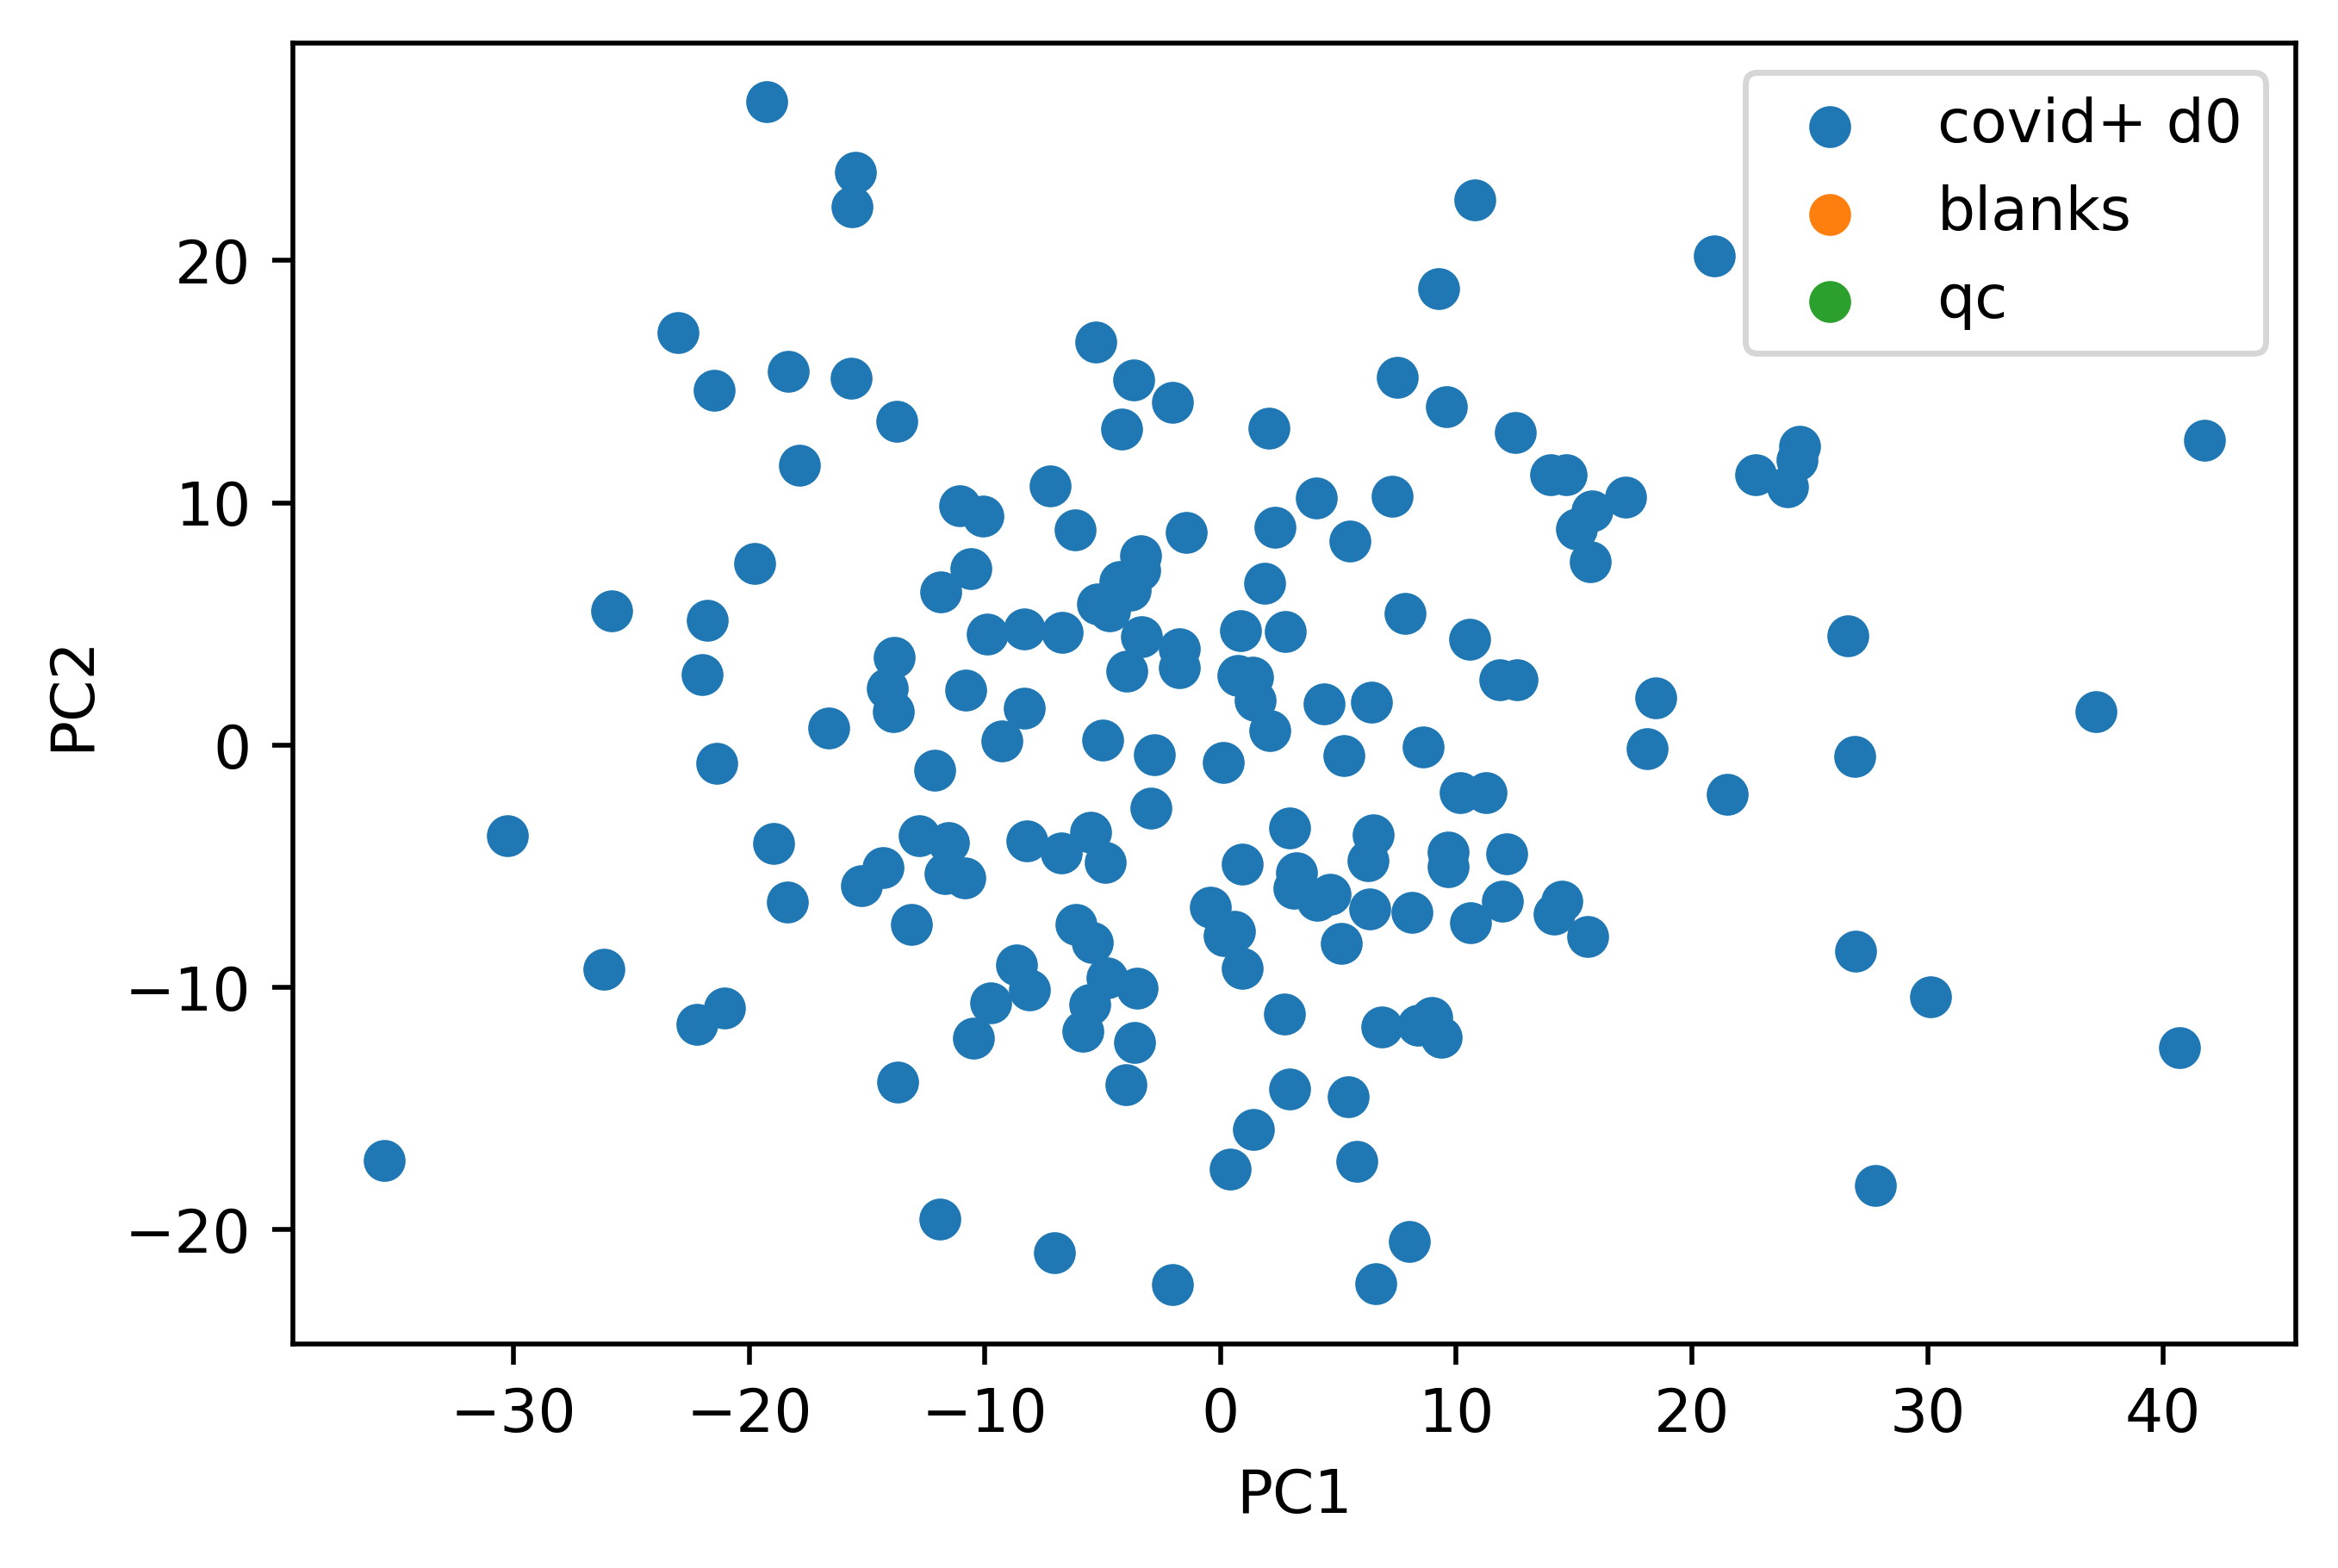

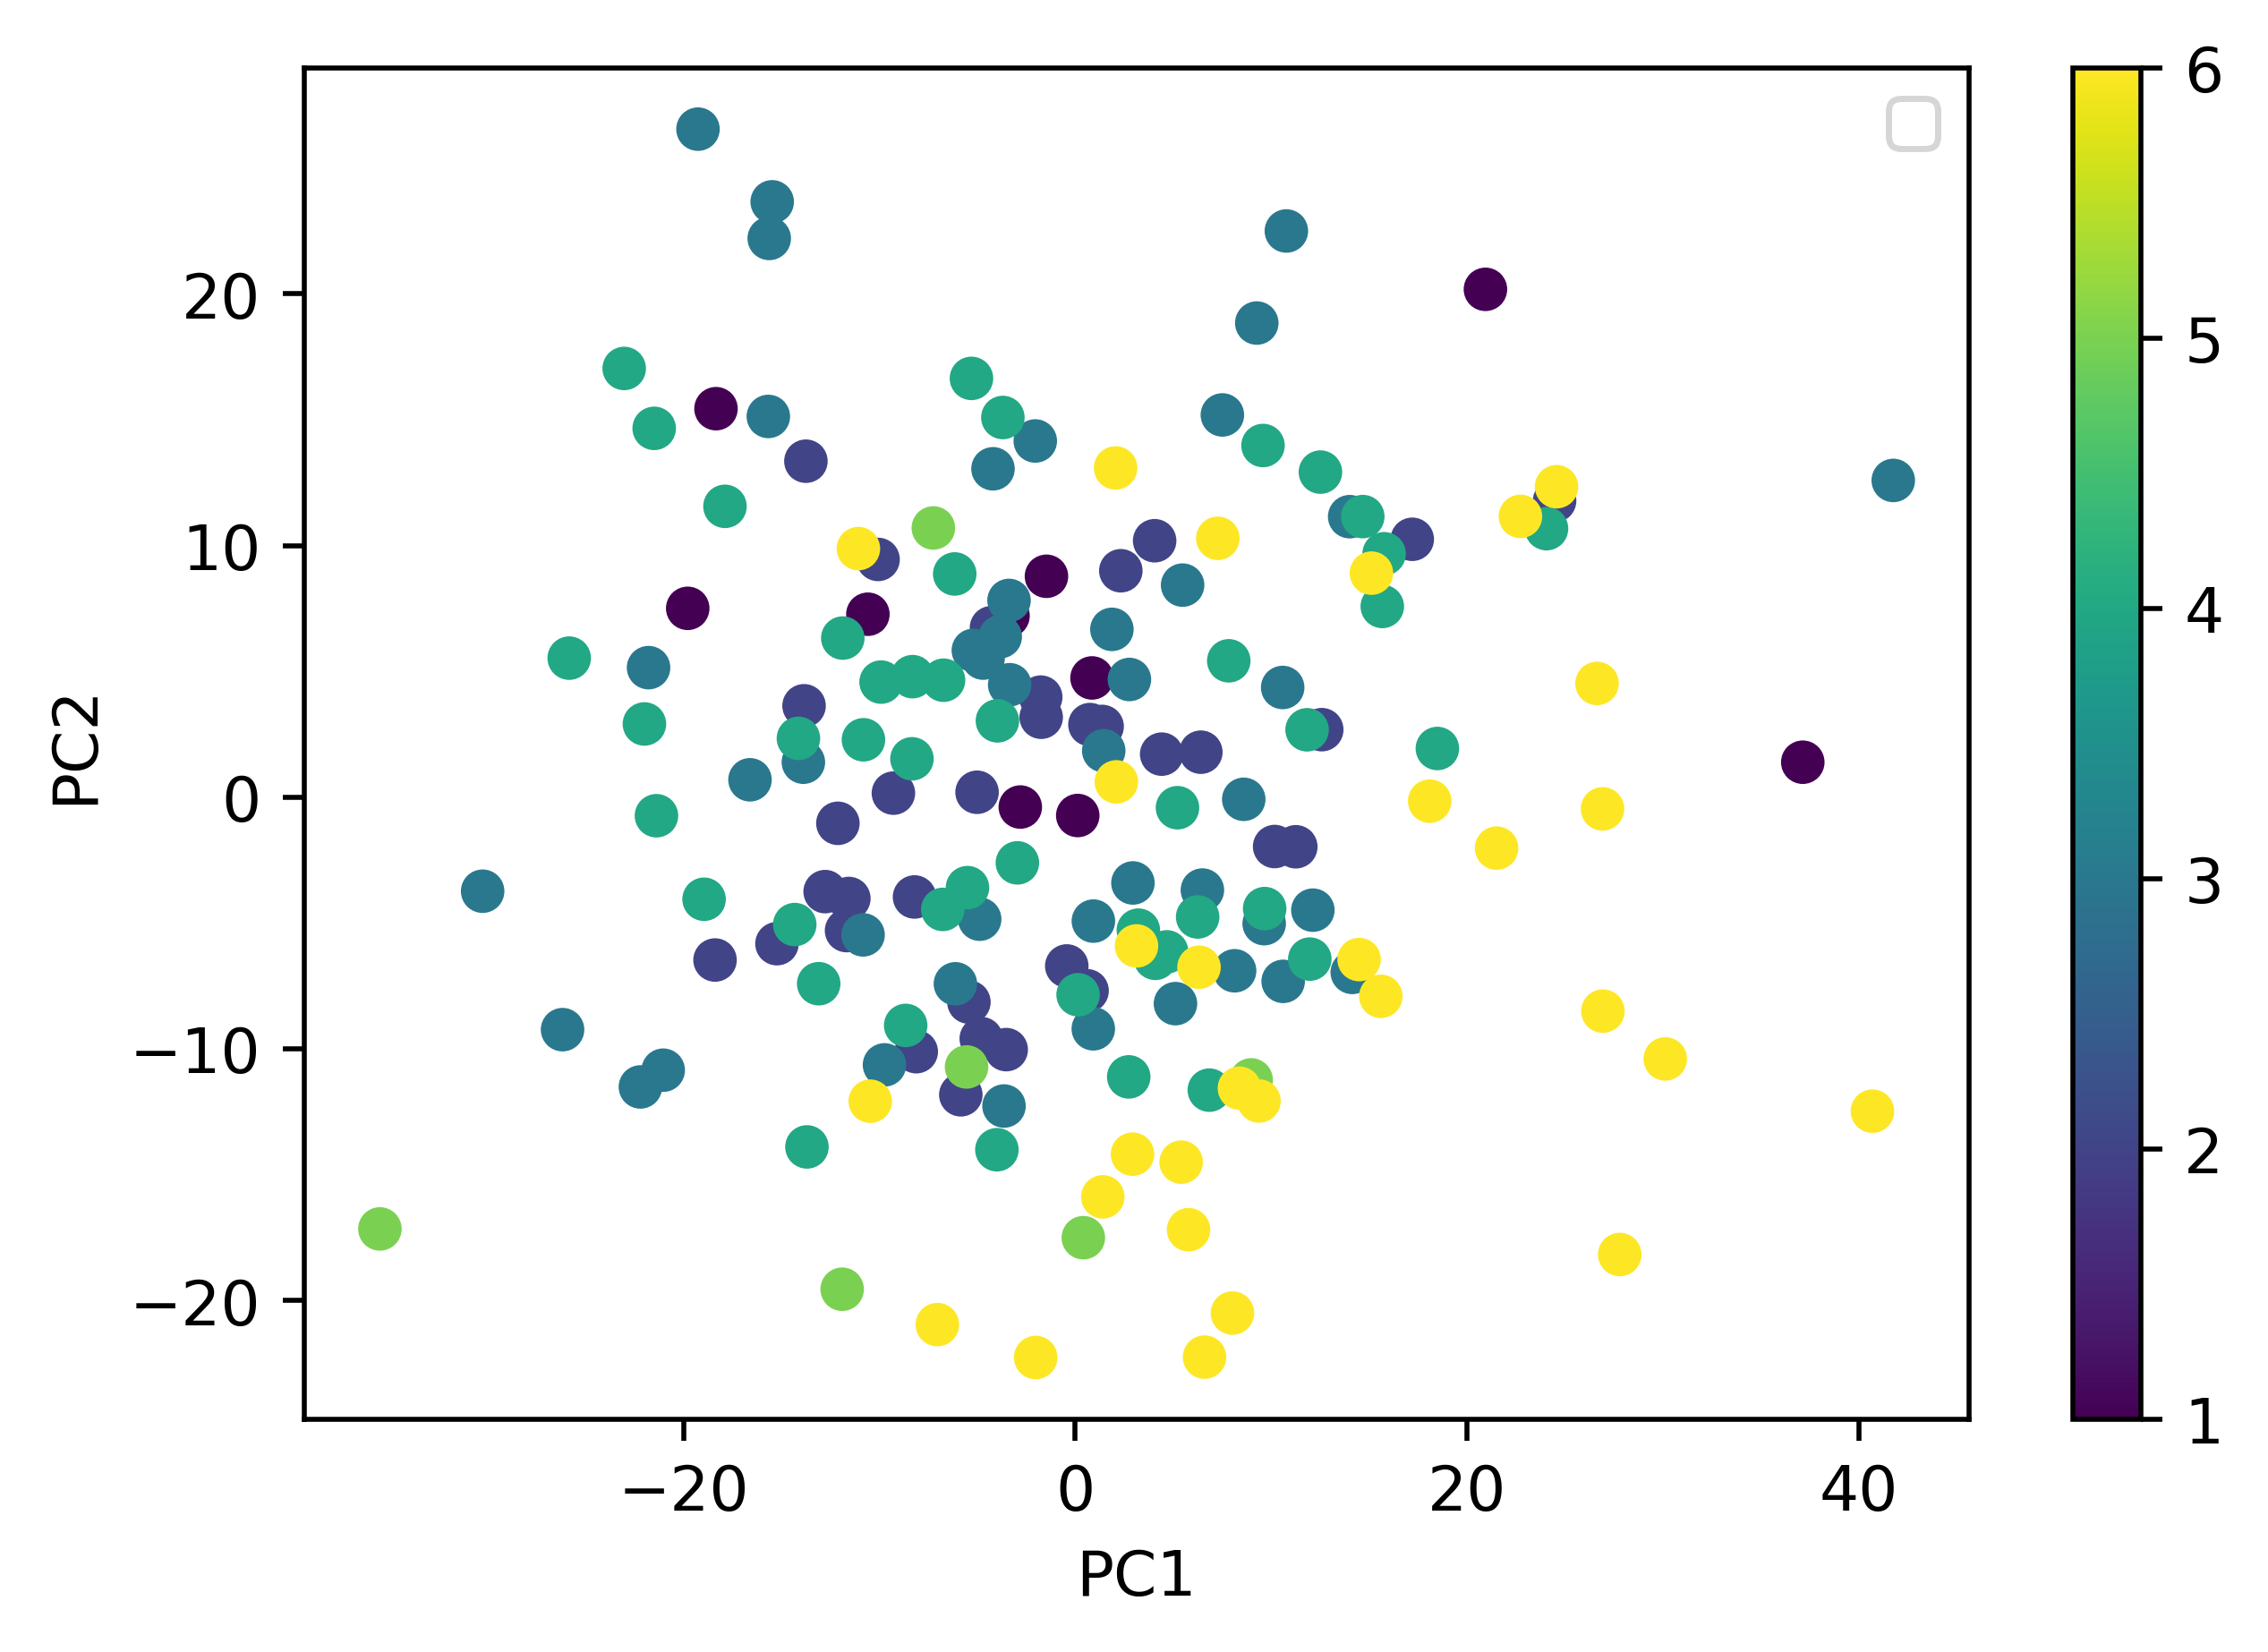

In [12]:
#visualize complete dataset

#first impute dataset
d_whole = np.concatenate((samp_int,blank_int,qc_int))
d_whole_imput = helper.imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
No handles with labels found to put in legend.


Adjusting data


Text(0, 0.5, 'PC2')

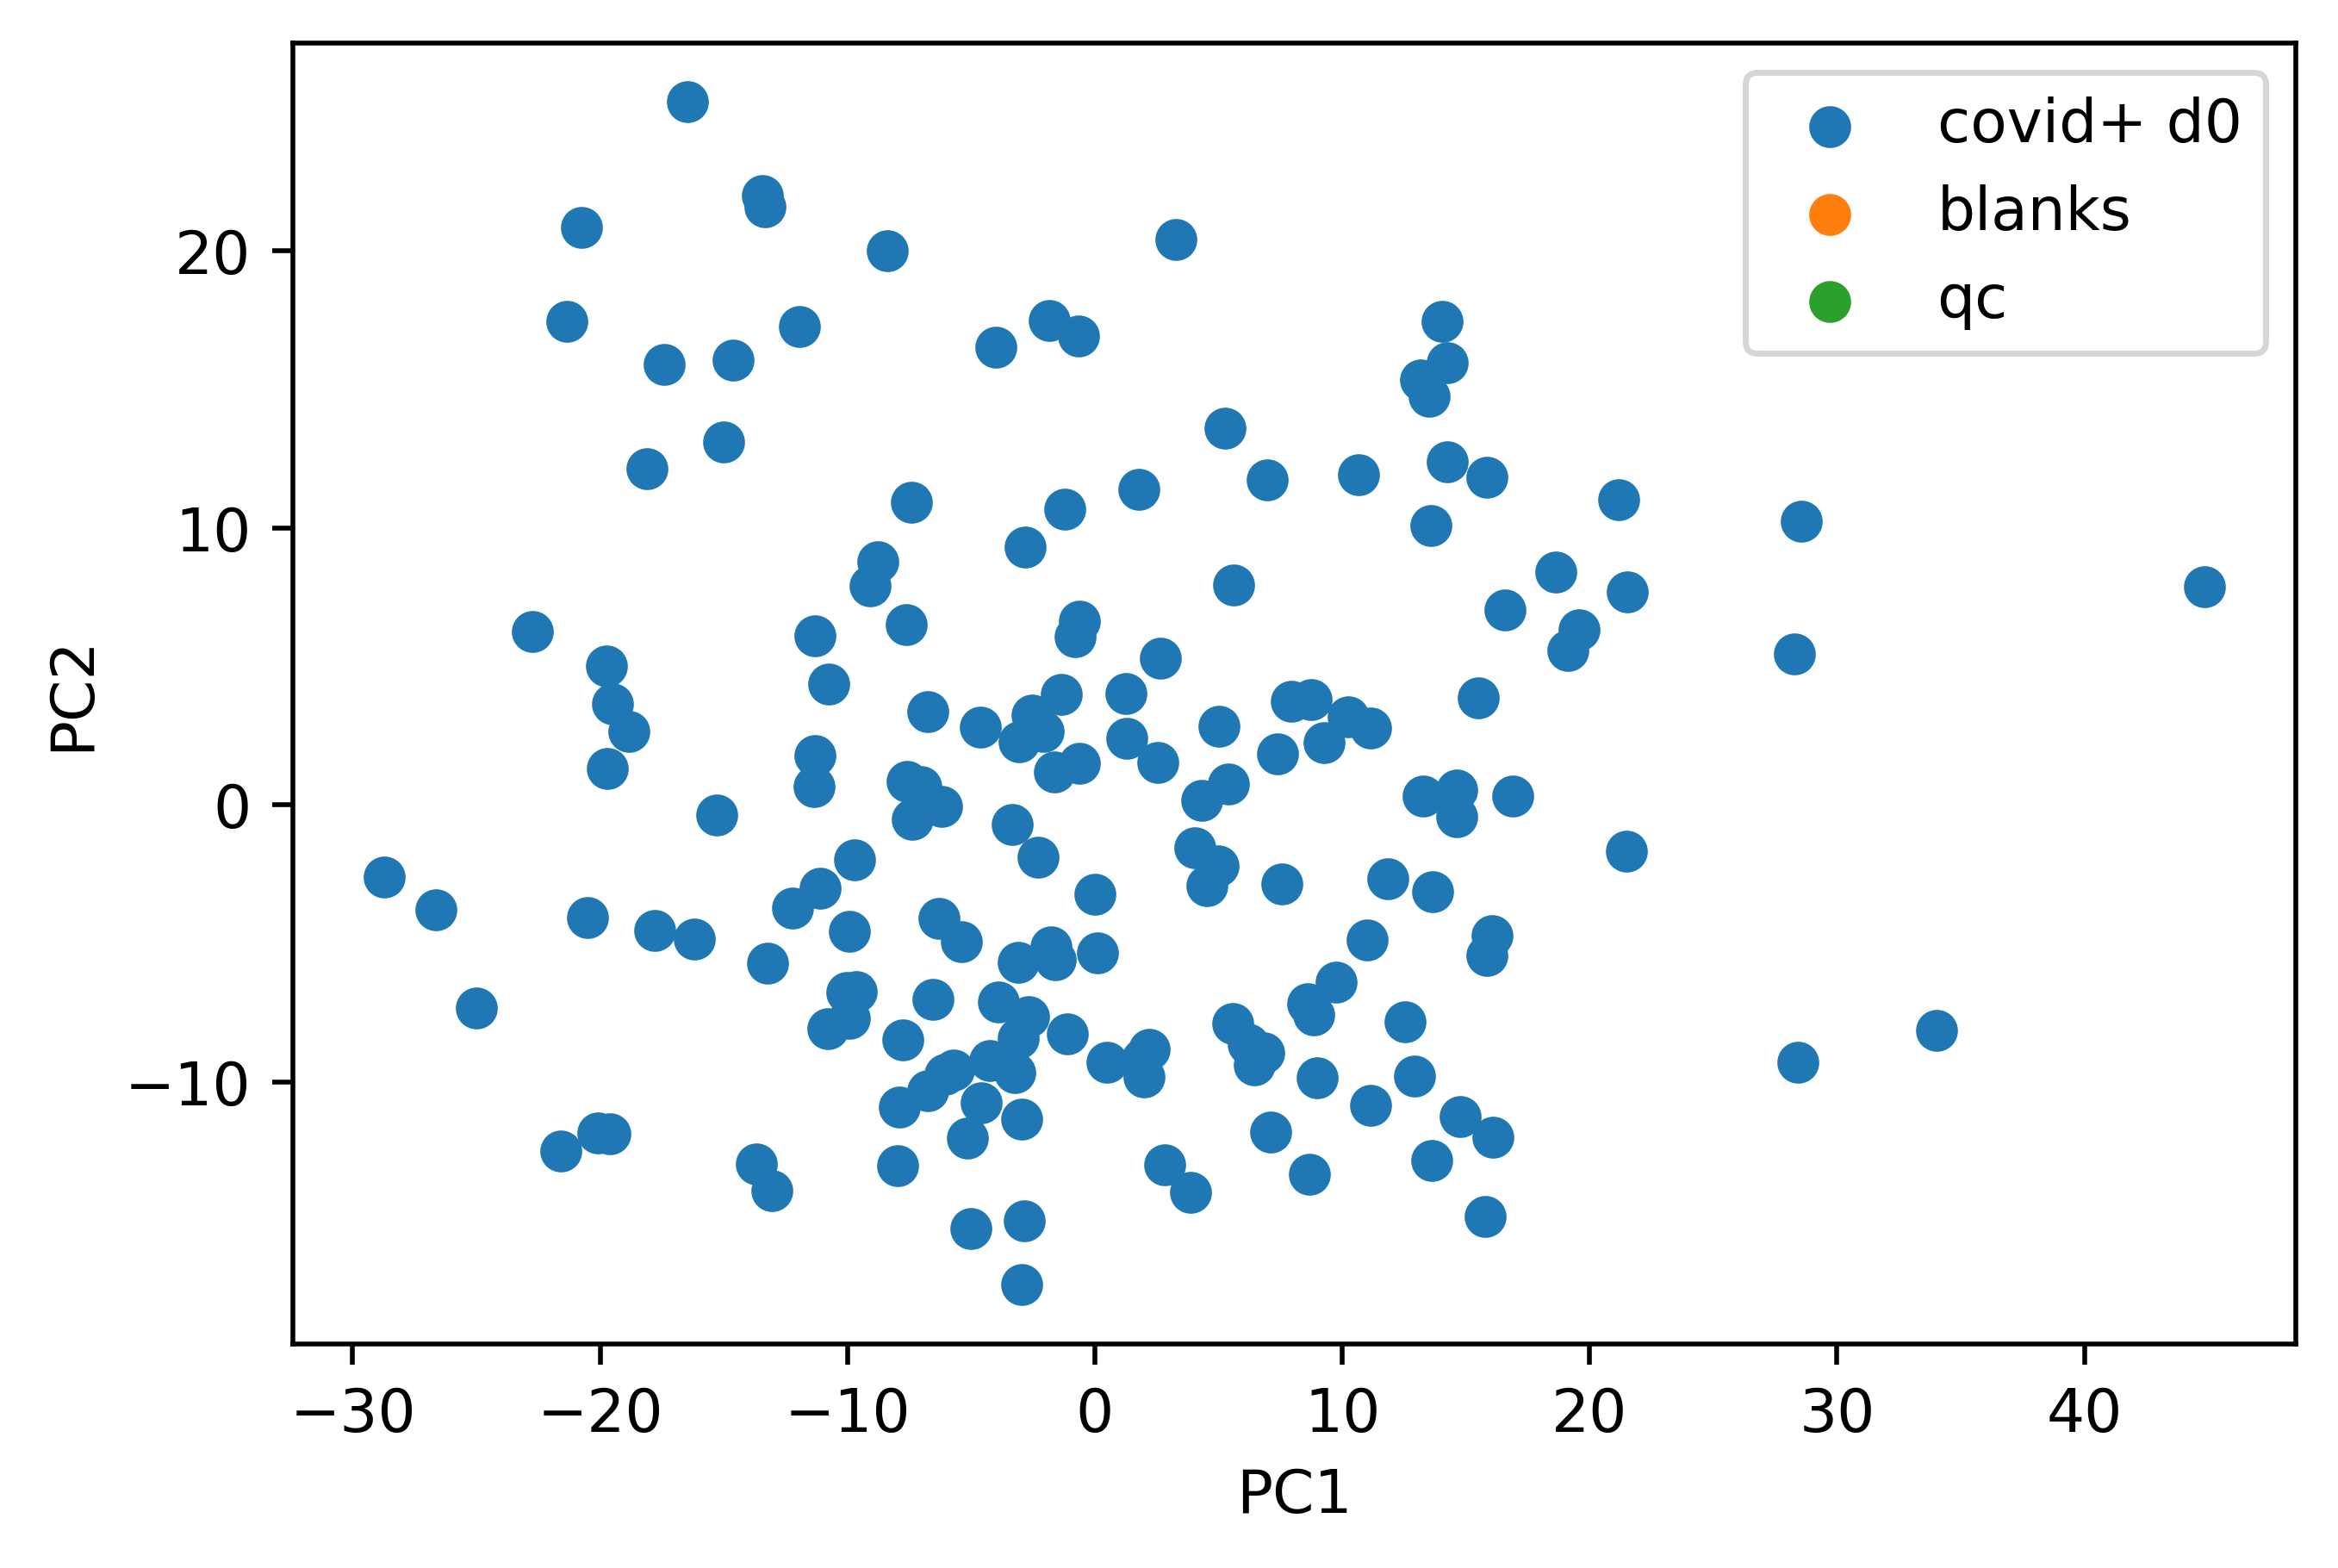

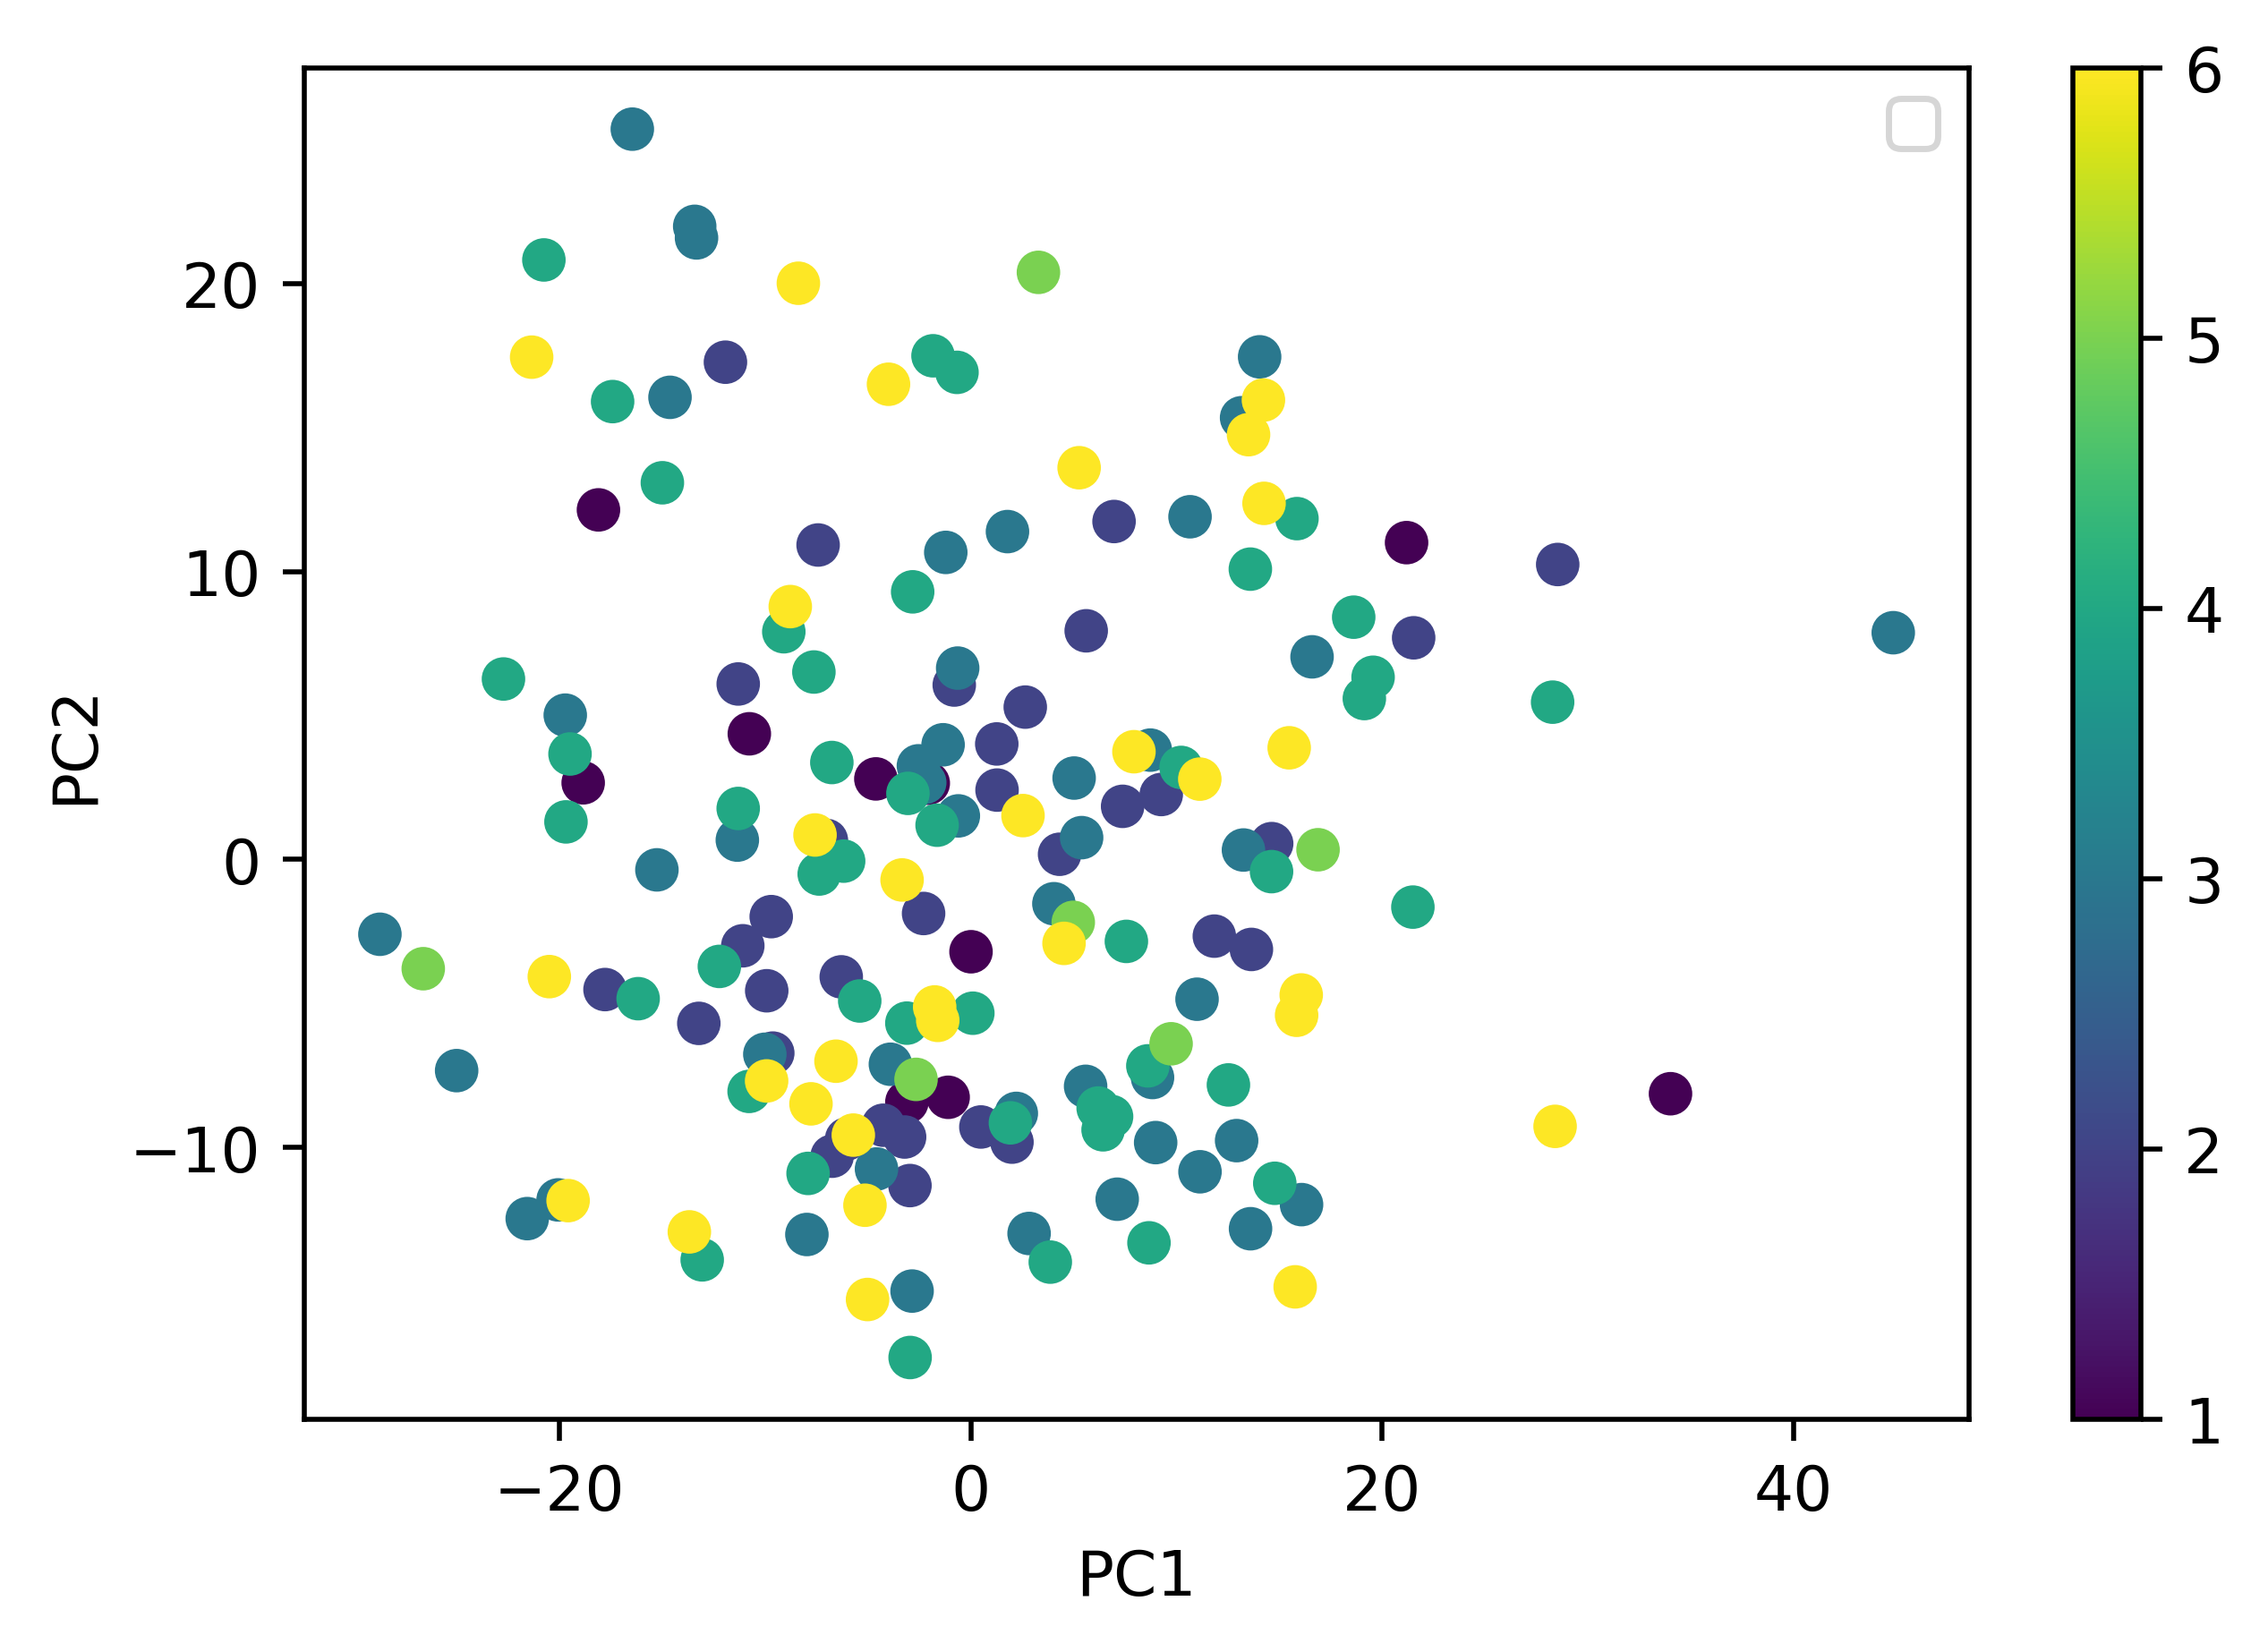

In [13]:
#now quantile normalize

d_whole_norm = combat.combat(pd.DataFrame(d_whole_imput.transpose()),np.concatenate((samp_batch,blank_batch,qc_batch))).transpose().to_numpy()

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



Text(0, 0.5, 'PC2')

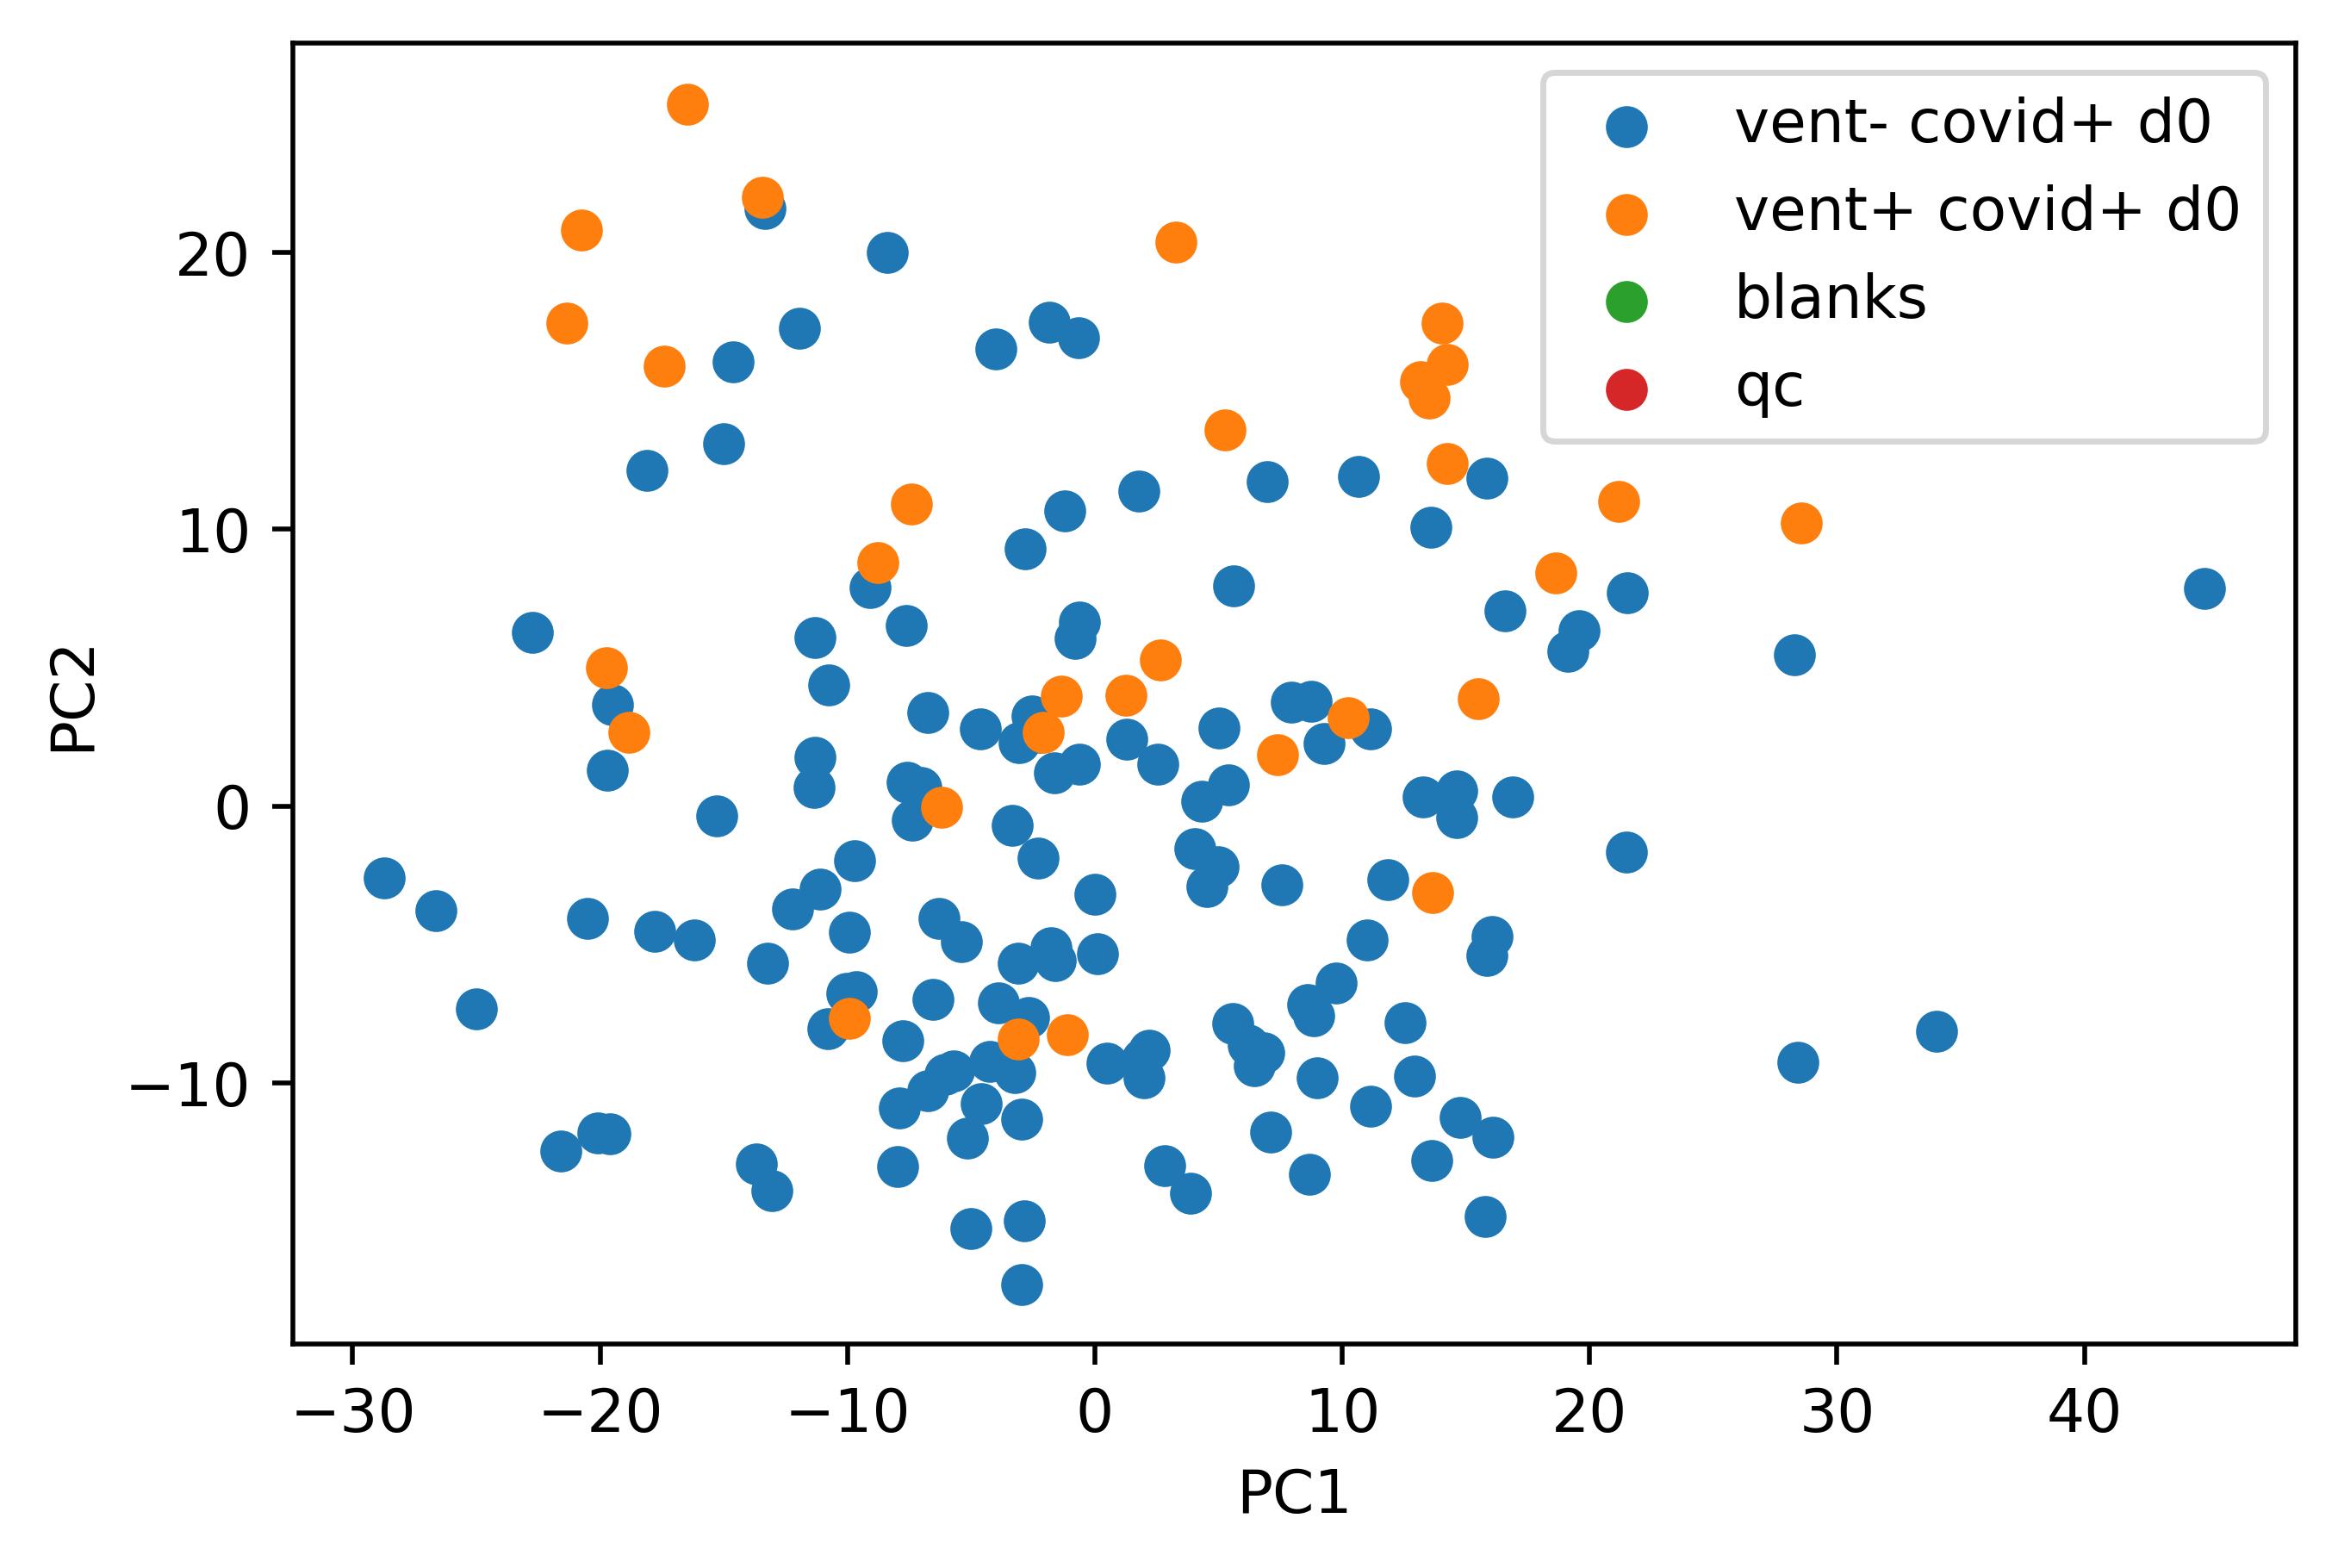

In [14]:
#now plot research samples by vent status
#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

#get vent pos/neg loadings
negSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 0]
posSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 1]
samp_load_vent_neg = loads[:len(samp_int)][negSamples]
samp_load_vent_pos = loads[:len(samp_int)][posSamples]

#get blanks and qc
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load_vent_neg[:,0],samp_load_vent_neg[:,1],label="vent- covid+ d0")
plt.scatter(samp_load_vent_pos[:,0],samp_load_vent_pos[:,1],label="vent+ covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



In [15]:
#create train and test sets for prediction model

#train batches on 1-4
#test on 5-6

trainBatches = [1,2,3,4]
testBatches = [5,6]


#get blanks for train/test
blank_train_index = [x for x in range(len(blank_batch)) if blank_batch[x] in trainBatches]
blank_test_index = [x for x in range(len(blank_batch)) if blank_batch[x] in testBatches]

blank_train_int = blank_int[blank_train_index]
blank_test_int = blank_int[blank_test_index]

blank_train_batch = blank_batch[blank_train_index]
blank_test_batch = blank_batch[blank_test_index]

#get samples for train/test
samp_train_index = [x for x in range(len(samp_batch)) if samp_batch[x] in trainBatches]
samp_test_index = [x for x in range(len(samp_batch)) if samp_batch[x] in testBatches]

samp_train_int = samp_int[samp_train_index]
samp_test_int = samp_int[samp_test_index]

samp_train_vent = samp_vent[samp_train_index]
samp_test_vent = samp_vent[samp_test_index]

samp_train_batch = samp_batch[samp_train_index]
samp_test_batch = samp_batch[samp_test_index]

#get qc for train/test

qc_train_index = [x for x in range(len(qc_batch)) if qc_batch[x] in trainBatches]
qc_test_index = [x for x in range(len(qc_batch)) if qc_batch[x] in testBatches]

qc_train_int = qc_int[qc_train_index]
qc_test_int = qc_int[qc_test_index] 

qc_train_batch = qc_batch[qc_train_index]
qc_test_batch = qc_batch[qc_test_index] 

#need to add vent and qcs

print("training examples: ",len(samp_train_int),"testing examples: ",len(samp_test_int))
print("training vent+ examples:, ",len([x for x in samp_train_vent if x == 1]),
      "training vent- examples:, ",len([x for x in samp_train_vent if x == 0]))
print("testing vent+ examples:, ",len([x for x in samp_test_vent if x == 1]),
      "testing vent- examples:, ",len([x for x in samp_test_vent if x == 0]))

training examples:  132 testing examples:  36
training vent+ examples:,  22 training vent- examples:,  110
testing vent+ examples:,  9 testing vent- examples:,  27


In [16]:
#set number of processors (n) and number of splits (k)
k = 20#len(samp_train_int)
n = 20
fc_to_test = [1]
alpha_to_test = [1e-3,1e-2,0.05,0.10,1.0]
methods = ["corr","stat"]
num_corr = np.linspace(0,1,10)
feat_params = []
for meth in methods:
    if meth == "corr":
        for nc in num_corr:
            feat_params.append((meth,nc))
    elif meth == "stat":
        for a in alpha_to_test:
            for fc in fc_to_test:
                feat_params.append((meth,a,fc))

#define model names, functions, and hyper parameters to test
model_names = ["Logistic Regression","ElasticNet","PLSDA","SVM","Random Forest"]
model_parameter_lists = [{"feat_selection":feat_params,"C":[0.001,0.01,.1,1,10,100],"l1_ratio":np.linspace(0,1,10)},
                         {"feat_selection":feat_params,"alpha":[0.001,0.01,.1,1,10,100],"l1_ratio":np.linspace(0,1,10)},
                         {"feat_selection":feat_params,"n_components":range(1,10)},
                         {"feat_selection":feat_params,"C":[1e-3,1e-2,1e-1,1,10,100],"kernel":["linear","poly","rbf","sigmoid"]},
                         {"feat_selection":feat_params,"max_features":["auto","log2",None],"max_depth":[None,1,5,10,20,50],"n_estimators": [int(x) for x in np.linspace(1,200,5)]}]

model_train_funcs = [helper.trainLogisticRegression,helper.trainElasticNet,helper.trainPLSDA,helper.trainSVM,helper.trainRF]
model_predict_funcs = [helper.predictLogisticRegression,helper.predictElasticNet,helper.predictPLSDA,helper.predictSVM,helper.predictRF]

#structure to store results
modeling_results_dict = {}
modeling_results_dict_training = {}
index = 0

if __name__ ==  '__main__': 
    #iterate over baselining methods
    for baseline in ["none","all"]:
        
        #get normalized training and testing data
        X_train,y_train,X_test,y_test,X_train_blank = helper.normalize_data(samp_train_int,blank_train_int,qc_train_int,samp_test_int, blank_test_int, qc_test_int,samp_train_batch,
                           blank_train_batch, qc_train_batch, samp_test_batch, blank_test_batch, qc_test_batch,samp_train_vent,samp_test_vent,baseline,plot=False)

        #iterate over model types
        for name,paramsToTry,trainFunc,predictFunc in zip(model_names,model_parameter_lists,model_train_funcs,model_predict_funcs):

            #optimize hyper parameters        
            results,err_cv,bestParams,log_pred = helper.optimizeHyperParams(paramsToTry,X_train,y_train,X_train_blank,mol_names,trainFunc,predictFunc,k=k,n=n)
            print(baseline,name)
            #get best parameters
            print(bestParams)
            plt.figure()
            selected_feats = helper.featureSelection(X_train,y_train,X_train_blank,mol_names,bestParams["feat_selection"],True,True)

            y_pred = predictFunc(log_pred,X_train)

            #assess training error
            err_train = helper.score(y_pred,y_train)
            print("training score: ",err_train)

            #print(sklearn.metrics.confusion_matrix(y_train,y_pred))

            #assess cross validation error
            y_pred,y_true = helper.crossVal(X_train,y_train,X_train_blank,mol_names,trainFunc,predictFunc,bestParams,k=k,numCores=n)

            err_cv = helper.score(y_pred,y_true)
            print("cv score: ",err_cv)
            #print(sklearn.metrics.confusion_matrix(y_true,y_pred))
            modeling_results_dict[index] = {"Model":name,"Params":bestParams,"Baseline":baseline,"Score":err_cv,"Training Score":err_train}

            index += 1

found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
none Logistic Regression
{'feat_selection': ('corr', 0.8888888888888888), 'C': 10, 'l1_ratio': 0.0}
training score:  0.6963850988476075
cv score:  0.42287917451234436
none ElasticNet
{'feat_selection': ('corr', 0.3333333333333333), 'alpha': 0.01, 'l1_ratio': 0.5555555555555556}
training score:  0.9999999999999998
cv score:  0.45301540324285305
none PLSDA
{'feat_selection': ('corr', 0.8888888888888888), 'n_components': 6}
training score:  0.9999999999999998
cv score:  0.529191177593257
none SVM
{'feat_selection': ('corr', 0.3333333333333333), 'C': 0.001, 'kernel': 'linear'}
training score:  0.4393939393939394
cv score:  0.2941176470588235
none Random Forest
{'feat_selection': ('corr', 0.4444444444444444), 'max_features': None, 'max_depth': 5, 'n_estimators': 100}
training score:  1.0
cv score:  0.20238095238095236


found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
all Logistic Regression
{'feat_selection': ('corr', 0.3333333333333333), 'C': 0.1, 'l1_ratio': 0.1111111111111111}
training score:  0.9903148366784731
cv score:  0.4663074477888833
all ElasticNet
{'feat_selection': ('corr', 0.3333333333333333), 'alpha': 0.01, 'l1_ratio': 0.5555555555555556}
training score:  0.9999999999999998
cv score:  0.45301540324285305
all PLSDA
{'feat_selection': ('corr', 0.8888888888888888), 'n_components': 6}
training score:  0.9999999999999998
cv score:  0.529191177593257
all SVM
{'feat_selection': ('corr', 1.0), 'C': 10, 'kernel': 'poly'}
training score:  1.0
cv score:  0.36111111111111116
all Random Forest
{'feat_selection': ('corr', 0.2222222222222222), 'max_features': 'auto', 'max_depth': 50, 'n_estimators': 1}
training score:  0.6087662337662337
cv score:  0.18548387096774194


<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

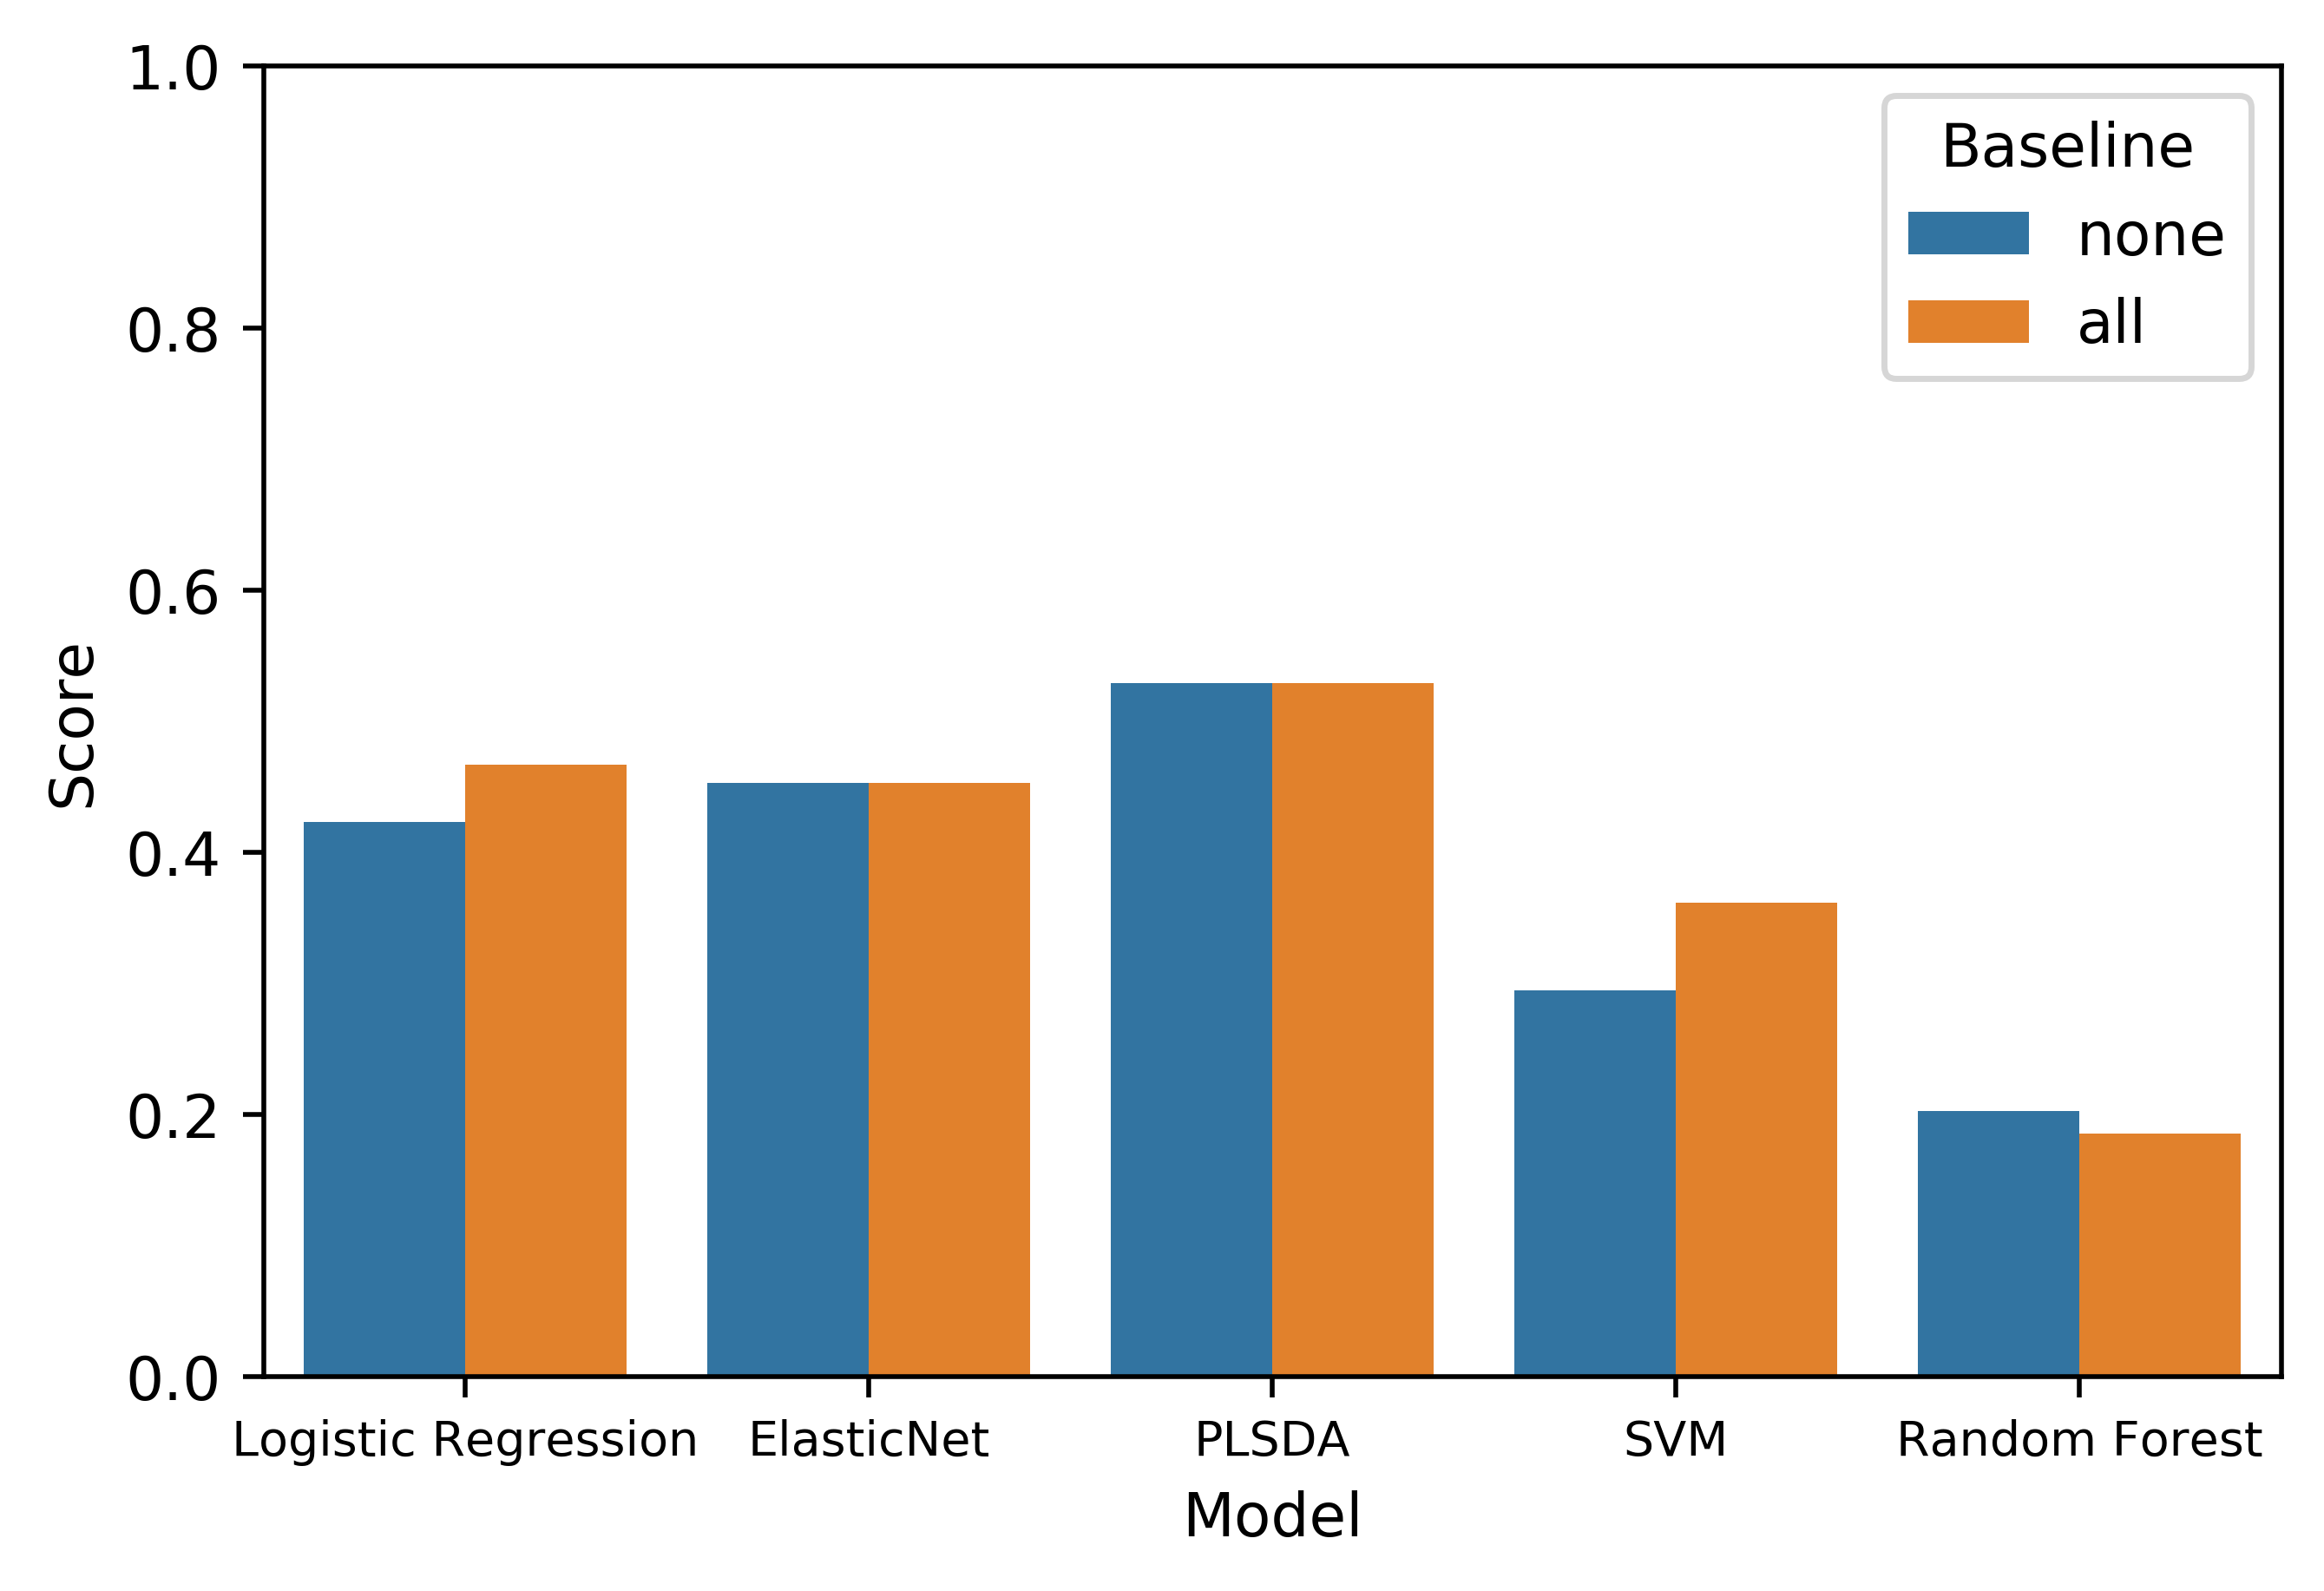

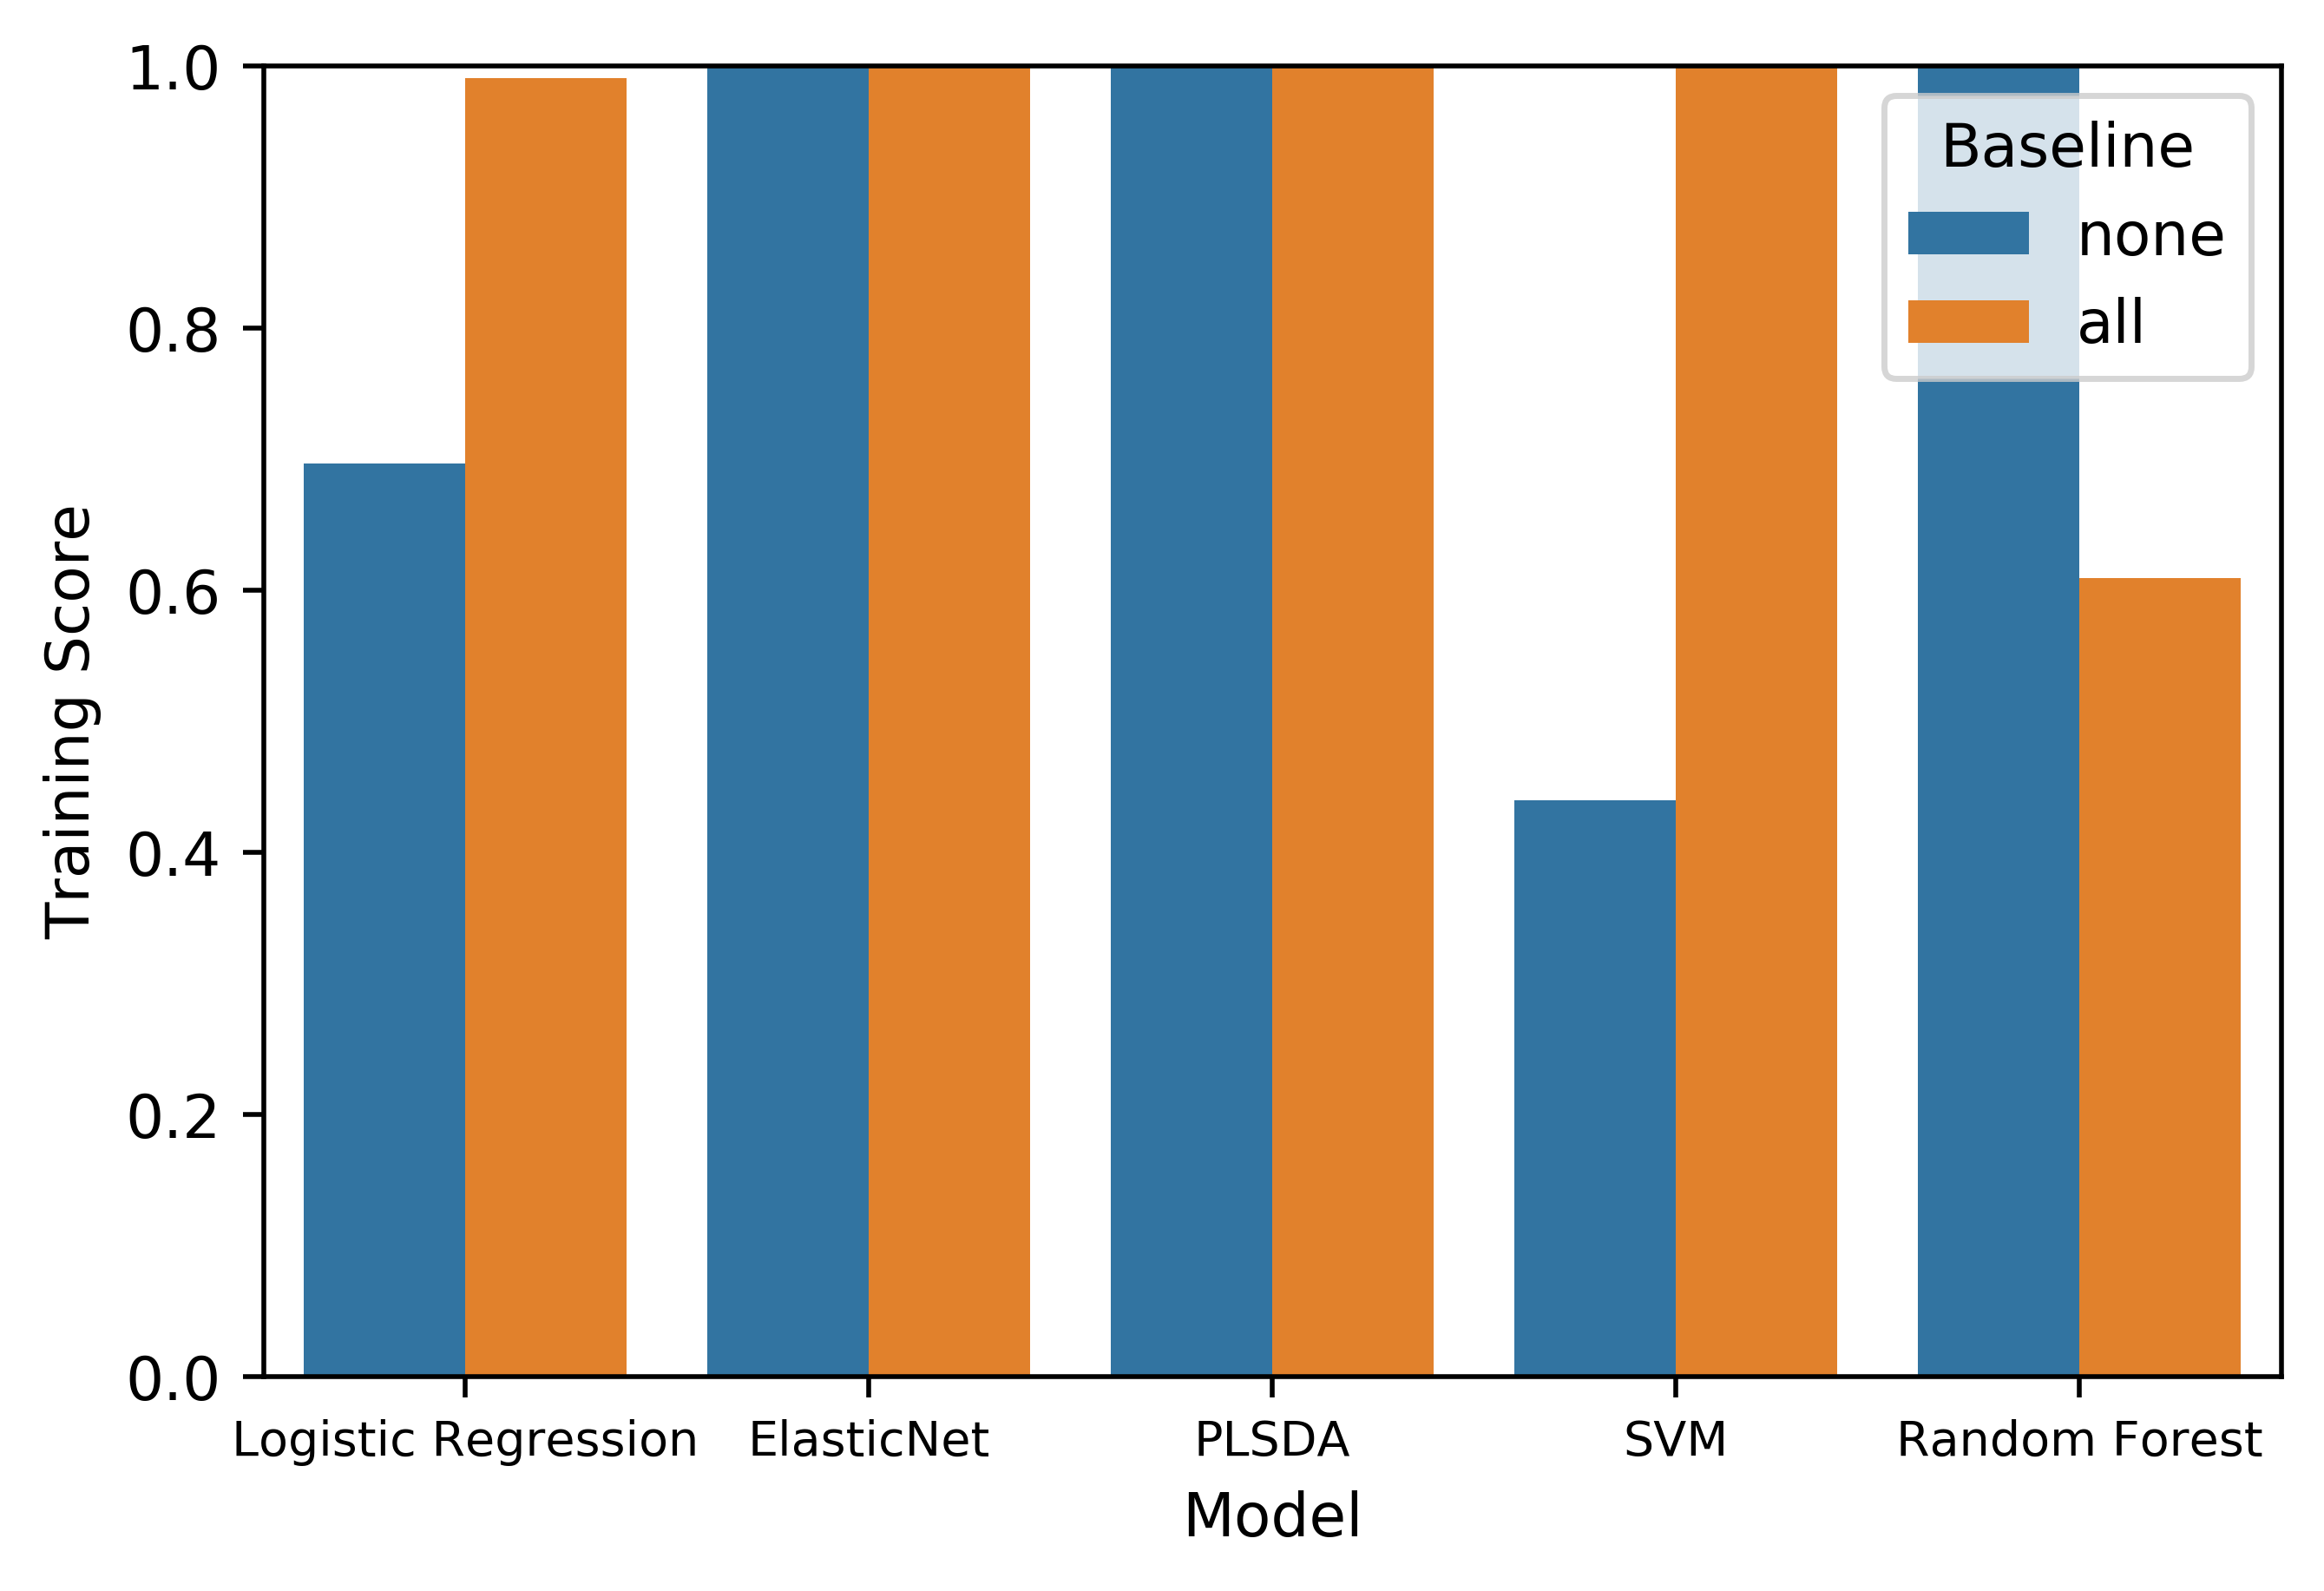

In [17]:
#make result dict a df
result_df = pd.DataFrame.from_dict(modeling_results_dict,orient="index")
#plot results
sb.barplot(x="Model",y="Score",hue="Baseline",data=result_df)
plt.xticks(fontsize=8)
plt.ylim((0,1))

plt.figure()
sb.barplot(x="Model",y="Training Score",hue="Baseline",data=result_df)
plt.xticks(fontsize=8)
plt.ylim((0,1))

#write results to files
pkl.dump(result_df,open("modeling_results_qTOF.pkl","wb"))
result_df.to_csv("../data/modeling_cv_results_qTOF.csv")

In [18]:
#write normalized data
